In [2]:
import pandas as pd

# Cargar el dataset
data = pd.read_csv("data_updated.csv")

# Rellenar valores faltantes (si existen)
data['Line'] = data['Line'].fillna('Unknown')
data['Incident'] = data['Incident'].fillna('Unknown')
data['Bound'] = data['Bound'].fillna('Unknown')
data['Min Delay'] = pd.to_numeric(data['Min Delay'], errors='coerce').fillna(0)


In [3]:
# Crear variable objetivo
data['Significant Delay'] = (data['Min Delay'] > 15).astype(int)

# Inspeccionar la distribución de la variable objetivo
print(data['Significant Delay'].value_counts())


Significant Delay
0    8816
1    2271
Name: count, dtype: int64


In [6]:
# Seleccionar características relevantes
features = ['Line', 'Incident', 'Day', 'Time']
target = 'Significant Delay'


In [7]:
from sklearn.preprocessing import OneHotEncoder

# Codificar variables categóricas
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(data[features])
y = data[target]


In [8]:
from sklearn.preprocessing import OneHotEncoder

# Codificar variables categóricas
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(data[features])
y = data[target]

In [9]:
from sklearn.model_selection import train_test_split

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Entrenar el modelo
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predicciones y evaluación
y_pred = clf.predict(X_test)
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred))


Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      1759
           1       0.59      0.33      0.42       459

    accuracy                           0.81      2218
   macro avg       0.72      0.63      0.66      2218
weighted avg       0.79      0.81      0.79      2218



In [11]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Reentrenar con datos balanceados
clf.fit(X_train_balanced, y_train_balanced)
y_pred_balanced = clf.predict(X_test)
print("Reporte de Clasificación (con SMOTE):\n", classification_report(y_test, y_pred_balanced))


Reporte de Clasificación (con SMOTE):
               precision    recall  f1-score   support

           0       0.85      0.92      0.89      1759
           1       0.56      0.37      0.44       459

    accuracy                           0.81      2218
   macro avg       0.71      0.65      0.66      2218
weighted avg       0.79      0.81      0.79      2218



In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='f1', cv=3, verbose=1)
grid_search.fit(X_train_balanced, y_train_balanced)

# Mejor modelo
best_clf = grid_search.best_estimator_
y_pred_best = best_clf.predict(X_test)
print("Reporte de Clasificación (Optimizado):\n", classification_report(y_test, y_pred_best))


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Reporte de Clasificación (Optimizado):
               precision    recall  f1-score   support

           0       0.85      0.93      0.89      1759
           1       0.57      0.38      0.45       459

    accuracy                           0.81      2218
   macro avg       0.71      0.65      0.67      2218
weighted avg       0.79      0.81      0.80      2218



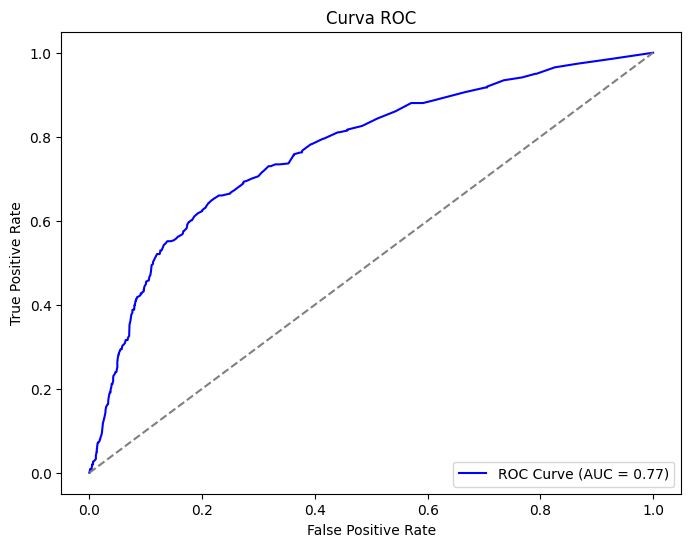

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Curva ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [15]:
from xgboost import XGBClassifier

# Entrenar XGBoost con penalización para clase minoritaria
xgb_clf_weighted = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss',
                                  learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8,
                                  scale_pos_weight=4)  # Penalización para la clase 1
xgb_clf_weighted.fit(X_train_balanced, y_train_balanced)

# Evaluar
y_pred_weighted = xgb_clf_weighted.predict(X_test)
print("Reporte de Clasificación con Pesos Ajustados:\n", classification_report(y_test, y_pred_weighted))


/Users/enriquegomeztagle/anaconda3/envs/ML/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:30:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Reporte de Clasificación con Pesos Ajustados:
               precision    recall  f1-score   support

           0       0.92      0.59      0.72      1759
           1       0.34      0.79      0.47       459

    accuracy                           0.64      2218
   macro avg       0.63      0.69      0.60      2218
weighted avg       0.80      0.64      0.67      2218



In [19]:
from lightgbm import LGBMClassifier

# Entrenar LightGBM
lgbm_clf = LGBMClassifier(random_state=42, learning_rate=0.2, max_depth=7, n_estimators=200, class_weight={0: 1, 1: 4})
lgbm_clf.fit(X_train_balanced, y_train_balanced)

# Evaluar
y_pred_lgbm = lgbm_clf.predict(X_test)
print("Reporte de Clasificación con LightGBM:\n", classification_report(y_test, y_pred_lgbm))


[LightGBM] [Info] Number of positive: 7057, number of negative: 7057
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4072
[LightGBM] [Info] Number of data points in the train set: 14114, number of used features: 345
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.800000 -> initscore=1.386294
[LightGBM] [Info] Start training from score 1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [21]:
# Crear una nueva característica de interacción
data['Line_Incident'] = data['Line'] + '_' + data['Incident']

# Reentrenar con la nueva característica
features = ['Line', 'Incident', 'Day', 'Time', 'Line_Incident']
X_encoded = encoder.fit_transform(data[features])

# Dividir y entrenar nuevamente
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Reporte de Clasificación con Interacciones:\n", classification_report(y_test, y_pred))


Reporte de Clasificación con Interacciones:
               precision    recall  f1-score   support

           0       0.84      0.93      0.89      1759
           1       0.56      0.32      0.41       459

    accuracy                           0.81      2218
   macro avg       0.70      0.63      0.65      2218
weighted avg       0.78      0.81      0.79      2218



In [22]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

# Definir modelos
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=4)
lgbm_clf = LGBMClassifier(random_state=42, learning_rate=0.1, max_depth=7, n_estimators=200, class_weight={0: 1, 1: 4})

# Ensemble
ensemble_clf = VotingClassifier(estimators=[('xgb', xgb_clf), ('lgbm', lgbm_clf)], voting='soft')
ensemble_clf.fit(X_train, y_train)

# Evaluar
y_pred_ensemble = ensemble_clf.predict(X_test)
print("Reporte de Clasificación con Ensemble:\n", classification_report(y_test, y_pred_ensemble))


/Users/enriquegomeztagle/anaconda3/envs/ML/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:32:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1812, number of negative: 7057
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 8869, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506676 -> initscore=0.026706
[LightGBM] [Info] Start training from score 0.026706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [23]:
from sklearn.ensemble import VotingClassifier

# Ajustar pesos en el ensemble
ensemble_clf_weighted = VotingClassifier(
    estimators=[('xgb', xgb_clf), ('lgbm', lgbm_clf)],
    voting='soft',
    weights=[1, 2]  # Damos más peso a LightGBM
)
ensemble_clf_weighted.fit(X_train, y_train)

# Evaluar
y_pred_ensemble_weighted = ensemble_clf_weighted.predict(X_test)
print("Reporte de Clasificación con Ensemble Ajustado:\n", classification_report(y_test, y_pred_ensemble_weighted))


/Users/enriquegomeztagle/anaconda3/envs/ML/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:33:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1812, number of negative: 7057
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 8869, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506676 -> initscore=0.026706
[LightGBM] [Info] Start training from score 0.026706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [24]:
from lightgbm import LGBMClassifier

# Reentrenar con pesos ajustados manualmente
lgbm_clf_focal = LGBMClassifier(random_state=42, learning_rate=0.1, max_depth=7, n_estimators=200, class_weight='balanced')
lgbm_clf_focal.fit(X_train, y_train)

# Evaluar
y_pred_focal = lgbm_clf_focal.predict(X_test)
print("Reporte de Clasificación con Focal Loss (LightGBM):\n", classification_report(y_test, y_pred_focal))


[LightGBM] [Info] Number of positive: 1812, number of negative: 7057
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 8869, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [25]:
from sklearn.calibration import CalibratedClassifierCV

# Calibrar el modelo LightGBM
calibrated_clf = CalibratedClassifierCV(lgbm_clf, method='sigmoid')
calibrated_clf.fit(X_train, y_train)

# Evaluar
y_pred_calibrated = calibrated_clf.predict(X_test)
print("Reporte de Clasificación con Calibración:\n", classification_report(y_test, y_pred_calibrated))


[LightGBM] [Info] Number of positive: 1450, number of negative: 5645
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 7095, number of used features: 122
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506772 -> initscore=0.027088
[LightGBM] [Info] Start training from score 0.027088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be